In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchtune
import pickle as pkl
import os

from typing import Literal, Any
from tabulate import tabulate
from dataclasses import dataclass
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Loader

In [3]:
IMG_DIM = 128
NUM_CHANNELS = 3
BATCH_SIZE = 512
NORMALIZE_MEAN = (0.485,0.456,0.406)
NORMALIZE_STD = (0.229,0.224,0.225)
NUM_CLASSES = 90
NUM_REAL_IMG_PER_CLASS = 60
NUM_AI_IMG_PER_CLASS = 30
REAL_IMG_TRAIN_PERCENTAGE = 0.5
REAL_IMG_TEST_PERCENTAGE = 0.5

In [4]:
def get_subset_indices(
    num_img_per_class: int,
    percent: float = 1.0,
    side: Literal["left", "right"] = "left",
) -> np.ndarray:
    indices = []
    for i in range(NUM_CLASSES):
        base = i * num_img_per_class
        class_size = int(num_img_per_class * percent)
        start = 0 if side == "left" else num_img_per_class - class_size
        indices.extend(
            list(np.arange(base + start, base + start + class_size))
        )
    return np.array(indices, dtype=np.int32)

In [5]:
def get_loader(
    real_img_dir: str = "./real_animals",
    ai_img_dir: str = "./ai_animals",
    real_img_percent: float = 1.0,
    ai_img_percent: float = 0.0,
    batch_size: int = BATCH_SIZE,
    num_workers: int = 0,
    shuffle: bool = True,
) -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Get train/test dataloaders for real and AI-generated images.
    """
    transform = v2.Compose([
        v2.Resize((IMG_DIM, IMG_DIM)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD),
    ])

    train_real_img_subset = torch.utils.data.Subset(
        torchvision.datasets.ImageFolder(
            root=real_img_dir,
            transform=transform,
            allow_empty=True,
        ),
        indices=get_subset_indices(NUM_REAL_IMG_PER_CLASS, percent=REAL_IMG_TRAIN_PERCENTAGE * real_img_percent, side="left"),
    )
    test_real_img_subset = torch.utils.data.Subset(
        torchvision.datasets.ImageFolder(
            root=real_img_dir,
            transform=transform,
            allow_empty=True,
        ),
        indices=get_subset_indices(NUM_REAL_IMG_PER_CLASS, percent=REAL_IMG_TEST_PERCENTAGE, side="right"),
    )
    ai_img_subset = torch.utils.data.Subset(
        torchvision.datasets.ImageFolder(
            root=ai_img_dir,
            transform=transform,
            allow_empty=True,
        ),
        indices=get_subset_indices(NUM_AI_IMG_PER_CLASS, percent=ai_img_percent, side="left"),
    )

    train_dataset = torchtune.datasets.ConcatDataset(datasets=[train_real_img_subset, ai_img_subset]) if ai_img_percent > 0.0 else train_real_img_subset
    train_img_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )
    test_img_dataloader = torch.utils.data.DataLoader(
        dataset=test_real_img_subset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )

    return train_img_dataloader, test_img_dataloader

# Models

### CNN

In [57]:
class CNN(nn.Module):
    def __init__(self, input_channels, n_classes):
        super(CNN, self).__init__()

        # set metadata
        self.input_channels = input_channels
        self.n_classes = n_classes
        self.FINAL_LAYER_SIZE = 4
        self.final_layer_channels = 40
        self.flatten_layer_size = self.final_layer_channels * self.FINAL_LAYER_SIZE * self.FINAL_LAYER_SIZE

        # dropout layers
        self.dropout50 = nn.Dropout(p=0.5)
        self.dropout10 = nn.Dropout(p=0.1)

        # set up layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=self.final_layer_channels, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(self.flatten_layer_size, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # 1: conv -> pool
        x = self.conv1(x)
        x = self.dropout10(torch.nn.functional.leaky_relu(x))
        x = self.pool1(x)

        # 2: conv -> pool
        x = self.conv2(x)
        x = self.dropout10(torch.nn.functional.leaky_relu(x))
        x = self.pool2(x)

        # 3: conv -> pool
        x = self.conv3(x)
        x = self.dropout10(torch.nn.functional.leaky_relu(x))
        x = self.pool3(x)

        # 4: conv -> pool
        x = self.conv4(x)
        x = self.dropout10(torch.nn.functional.leaky_relu(x))
        x = self.pool4(x)

        # 5: conv -> pool
        x = self.conv5(x)
        x = self.dropout10(torch.nn.functional.leaky_relu(x))
        x = self.pool5(x)

        # flatten the features (the first dimension is batch size)
        x = x.view(-1, self.flatten_layer_size)

        # fc layers
        x = self.dropout50(torch.nn.functional.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [58]:
summary(CNN(input_channels=3, n_classes=NUM_CLASSES).to(device), (3, IMG_DIM, IMG_DIM), batch_size=BATCH_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [512, 8, 128, 128]             224
           Dropout-2         [512, 8, 128, 128]               0
         MaxPool2d-3           [512, 8, 64, 64]               0
            Conv2d-4          [512, 16, 64, 64]           1,168
           Dropout-5          [512, 16, 64, 64]               0
         MaxPool2d-6          [512, 16, 32, 32]               0
            Conv2d-7          [512, 24, 32, 32]           3,480
           Dropout-8          [512, 24, 32, 32]               0
         MaxPool2d-9          [512, 24, 16, 16]               0
           Conv2d-10          [512, 32, 16, 16]           6,944
          Dropout-11          [512, 32, 16, 16]               0
        MaxPool2d-12            [512, 32, 8, 8]               0
           Conv2d-13            [512, 40, 8, 8]          11,560
          Dropout-14            [512, 4

### Combined Pre-trained

In [59]:
def CombinedResNet50(frozen: bool = False) -> nn.Module:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    if frozen:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(2048, NUM_CLASSES)
    return model

In [60]:
summary(CombinedResNet50(True).to(device), (3, IMG_DIM, IMG_DIM), batch_size=BATCH_SIZE, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 64, 64, 64]           9,408
       BatchNorm2d-2          [512, 64, 64, 64]             128
              ReLU-3          [512, 64, 64, 64]               0
         MaxPool2d-4          [512, 64, 32, 32]               0
            Conv2d-5          [512, 64, 32, 32]           4,096
       BatchNorm2d-6          [512, 64, 32, 32]             128
              ReLU-7          [512, 64, 32, 32]               0
            Conv2d-8          [512, 64, 32, 32]          36,864
       BatchNorm2d-9          [512, 64, 32, 32]             128
             ReLU-10          [512, 64, 32, 32]               0
           Conv2d-11         [512, 256, 32, 32]          16,384
      BatchNorm2d-12         [512, 256, 32, 32]             512
           Conv2d-13         [512, 256, 32, 32]          16,384
      BatchNorm2d-14         [512, 256,

c:\Users\igort\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


# Hyper Parameter Tuning

In [6]:
@dataclass
class Result:
    train_losses: list[float]
    avg_train_accuracies: list[float]
    test_losses: list[float]
    test_accuracies: np.ndarray
    avg_test_accuracies: list[float]
    test_precision: np.ndarray
    test_recall: np.ndarray
    test_f1score: np.ndarray
    avg_test_precision: float
    avg_test_recall: float
    avg_test_f1score: float

DIFF_METRICS = {
    "Train Accuracy": {
        "key": "avg_train_accuracies",
        "get_value": lambda x: x[-1]*100.0,
    },
    "Test Accuracy": {
        "key": "avg_test_accuracies",
        "get_value": lambda x: x[-1]*100.0,
    },
    "Test Precision": {
        "key": "avg_test_precision",
        "get_value": lambda x: x*100.0,
    },
    "Test Recall": {
        "key": "avg_test_recall",
        "get_value": lambda x: x*100.0,
    },
    "Test F1 Score": {
        "key": "avg_test_f1score",
        "get_value": lambda x: x*100.0,
    }
}

## Visualizing Result Helpers

In [7]:
def load_result(model_params: dict, with_details: bool = True) -> Result:
    details = f"_{model_params["epochs"]}e_{str(model_params["learning_rate"])[2:]}lr_{str(model_params["weight_decay"])[2:]}wd" if with_details else ""
    with open(f"./results/{model_params["name"]}{details}.pkl", "rb") as f:
        result = pkl.load(f)
    return result

In [8]:
def save_result(result: Result, model_params: dict, with_details: bool = True) -> None:
    details = f"_{model_params["epochs"]}e_{str(model_params["learning_rate"])[2:]}lr_{str(model_params["weight_decay"])[2:]}wd" if with_details else ""
    filepath = f"./results/{model_params["name"]}{details}.pkl"
    if os.path.isfile(filepath):
        print("Error: File already exists, not overwriting.")
        return
    with open(filepath, "wb") as f:
        pkl.dump(result, f)

In [9]:
def print_basic_results(result: Result):
    print(f"Train Loss: {result.train_losses[-1]}")
    print(f"Train Accuracy: {result.avg_train_accuracies[-1] * 100}%\n")
    print(f"Test Loss: {result.test_losses[-1]}")
    print(f"Test Accuracy: {result.avg_test_accuracies[-1] * 100}%\n")
    print(f"Test Precision: {result.avg_test_precision * 100}%")
    print(f"Test Recall: {result.avg_test_recall * 100}%")
    print(f"Test F1 Score: {result.avg_test_f1score * 100}%")

In [10]:
def plot_diff_table(results: dict[str, Result], title: str, metrics: dict[str, dict[str, Any]]) -> None:
    metric_names = list(metrics.keys())
    values = []
    for result_name, result in results.items():
        row_array = [result_name]
        for _, metric in metrics.items():
            value = str(np.round(metric["get_value"](result.__getattribute__(metric["key"])), decimals=4)) + "%"
            row_array.append(value)
        values.append(row_array)
    print(tabulate(values, headers=metric_names, tablefmt="rounded_grid"))

In [11]:
def plot_loss_accuracy(result: Result) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.4)

    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].plot(result.train_losses, label="Train Loss", color="blue")
    ax[0].plot(result.test_losses, label="Test Loss", color="red")
    ax[0].legend()
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].grid(axis="both", linestyle="--", alpha=0.7)

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].plot(np.array(result.avg_train_accuracies)*100, label="Train Accuracy", color="blue")
    ax[1].plot(np.array(result.avg_test_accuracies)*100, label="Test Accuracy", color="red")
    ax[1].legend()
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(axis="both", linestyle="--", alpha=0.7)

In [24]:
def plot_loss_accuracy_diff(result_left: Result, result_right: Result, left_name: str, right_name: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.4)

    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].plot(result_left.train_losses, label=f"{left_name}Train Loss", color="blue")
    ax[0].plot(result_left.test_losses, label=f"{left_name}Test Loss", color="red")
    ax[0].plot(result_right.train_losses, label=f"{right_name}Train Loss", color="cyan")
    ax[0].plot(result_right.test_losses, label=f"{right_name}Test Loss", color="orange")
    ax[0].legend()
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].grid(axis="both", linestyle="--", alpha=0.7)

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].plot(np.array(result_left.avg_train_accuracies)*100, label=f"{left_name}Train Accuracy", color="blue")
    ax[1].plot(np.array(result_left.avg_test_accuracies)*100, label=f"{left_name}Test Accuracy", color="red")
    ax[1].plot(np.array(result_right.avg_train_accuracies)*100, label=f"{right_name}Train Accuracy", color="cyan")
    ax[1].plot(np.array(result_right.avg_test_accuracies)*100, label=f"{right_name}Test Accuracy", color="orange")
    ax[1].legend()
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(axis="both", linestyle="--", alpha=0.7)

In [12]:
def plot_improvement_by_class(
    result_left: Result,
    result_right: Result,
    metric: Literal["test_accuracies", "test_precision", "test_recall", "test_f1score"],
    classes: list[str],
    title: str = "Changes by Class",
    multiply_by: float = 1.0,
) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

    diffs = np.array(result_right.__getattribute__(metric) - result_left.__getattribute__(metric))*multiply_by
    sorted_indices = np.argsort(diffs)
    diffs = diffs[sorted_indices]
    classes = np.array(classes)[sorted_indices]

    mask_positive = diffs >= 0
    mask_negative = diffs < 0

    negative = ax.bar(classes[mask_negative], diffs[mask_negative], color="red")
    ax.bar_label(negative, np.round(diffs[mask_negative], decimals=1), label_type="edge", rotation=90)
    
    positive = ax.bar(classes[mask_positive], diffs[mask_positive], color="green")
    ax.bar_label(positive, np.round(diffs[mask_positive], decimals=1), label_type="edge", rotation=90)

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel(f"Change in {metric.replace('_', ' ').title()}")

    diff_range = max(diffs) - min(diffs)
    ax.set_ylim(bottom=min(diffs) - 0.2*diff_range, top=max(diffs) + 0.2*diff_range)
    ax.axhline(0, color="black", lw=1, ls="-")

In [13]:
def plot_diff_barchart(results: dict[str, Result], title: str, metrics: dict[str, dict[str, Any]]) -> None:
    metric_names = list(metrics.keys())
    x = np.arange(len(metrics))
    total_width = 0.5
    width = total_width / len(results)
    extra_spacing = 0.05*total_width
    offsets = np.linspace((-total_width/2) + (width/2) - extra_spacing, (total_width/2) - (width/2) + extra_spacing, len(results))
    values = {}
    max_value = 0.0
    for result_name, result in results.items():
        for _, metric in metrics.items():
            if result_name not in values:
                values[result_name] = []
            value = metric["get_value"](result.__getattribute__(metric["key"]))
            values[result_name].append(value)
            if value > max_value:
                max_value = value

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    for i, result_name in enumerate(values):
        bars = ax.bar(x + offsets[i], values[result_name], width, label=result_name)
        ax.bar_label(bars, np.round(values[result_name], decimals=1), label_type="edge", rotation=90)

    ax.set_title(title)
    ax.set_xlabel("Metric")
    ax.set_ylabel("Percent (%)")
    ax.set_xticks(x, metric_names)
    ax.legend(ncols=3)
    ax.set_ylim(bottom=0, top=max_value + 0.2*max_value)

## Main Training Function

In [14]:
def train_and_test_model(
        model: nn.Module,
        optimizer: optim.Optimizer,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        E: int,
        verbose: Literal["none", "prints", "epoch_tqdm", "loader_tqdm"] = "epoch_tqdm",
    ) -> Result:
    """
    Train and test the given model with the given parameters.
    """
    loss_function = nn.CrossEntropyLoss().to(device)

    accuracy_metric = MulticlassAccuracy(average='none', num_classes=NUM_CLASSES).to(device)
    precision_metric = MulticlassPrecision(average='none', num_classes=NUM_CLASSES).to(device)
    recall_metric = MulticlassRecall(average='none', num_classes=NUM_CLASSES).to(device)
    f1_metric = MulticlassF1Score(average='none', num_classes=NUM_CLASSES).to(device)

    train_losses = []
    avg_train_accuracies = []
    test_losses = []
    test_accuracies = 0
    avg_test_accuracies = []
    test_precision = 0
    test_recall = 0
    test_f1score = 0
    avg_test_precision = 0
    avg_test_recall = 0
    avg_test_f1score = 0

    for epoch in tqdm(range(E), total=E, disable=verbose!="epoch_tqdm"):
        # TRAINING
        model.train()
        batch_losses = []
        accuracy_metric.reset()
        for images, labels in tqdm(train_loader, total=len(train_loader), disable=verbose!="loader_tqdm"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            accuracy_metric.update(outputs, labels)
        train_loss = np.mean(np.array(batch_losses))
        train_losses.append(train_loss)
        train_acc = accuracy_metric.compute()
        avg_train_accuracies.append(train_acc.mean().item())

        # TESTING
        model.eval()
        test_batch_losses = []
        accuracy_metric.reset()
        precision_metric.reset()
        recall_metric.reset()
        for images, labels in tqdm(test_loader, total=len(test_loader), disable=verbose!="loader_tqdm"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_batch_losses.append(loss_function(outputs, labels).item())
            accuracy_metric.update(outputs, labels)
            if epoch >= E - 1:
                precision_metric.update(outputs, labels)
                recall_metric.update(outputs, labels)
                f1_metric.update(outputs, labels)
        test_loss = np.mean(np.array(test_batch_losses))
        test_losses.append(test_loss)
        test_acc = accuracy_metric.compute()
        avg_test_accuracies.append(test_acc.mean().item())
        if epoch >= E - 1:
            test_accuracies = test_acc.cpu().numpy()
            test_precision = precision_metric.compute().cpu().numpy()
            test_recall = recall_metric.compute().cpu().numpy()
            test_f1score = f1_metric.compute().cpu().numpy()
            avg_test_precision = test_precision.mean().item()
            avg_test_recall = test_recall.mean().item()
            avg_test_f1score = test_f1score.mean().item()

        if verbose=="prints":
            print(f"Epoch [{epoch+1}/{E}]: Train Accuracy: {avg_train_accuracies[-1]*100:.2f}%, Train Loss: {train_loss:.4f}, Test Accuracy: {avg_test_accuracies[-1]*100:.2f}%, Test Loss: {test_loss:.4f}")

    print(f"\nEvaluation results:\nTrain Accuracy: {avg_train_accuracies[-1]*100:.2f}%, Train Loss: {train_loss:.4f}\nTest Accuracy: {avg_test_accuracies[-1]*100:.2f}%, Test Loss: {test_loss:.4f}")

    return Result(
        train_losses=train_losses,
        avg_train_accuracies=avg_train_accuracies,
        test_losses=test_losses,
        test_accuracies=test_accuracies,
        avg_test_accuracies=avg_test_accuracies,
        test_precision=test_precision,
        test_recall=test_recall,
        test_f1score=test_f1score,
        avg_test_precision=avg_test_precision,
        avg_test_recall=avg_test_recall,
        avg_test_f1score=avg_test_f1score,
    )

## Tuning Code

In [69]:
train_loader, test_loader = get_loader(real_img_percent=1.0, ai_img_percent=0.0, num_workers=0)

In [49]:
model_params = {
    "name": "combined_tune",
    "learning_rate": 0.001,
    "weight_decay": 0.001,
    "epochs": 20,
}
model = CombinedResNet50(frozen=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=model_params["learning_rate"], weight_decay=model_params["weight_decay"])
results_1 = train_and_test_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    E=model_params["epochs"],
    verbose="epoch_tqdm",
)

100%|██████████| 20/20 [17:04<00:00, 51.21s/it]


Evaluation results:
Train Accuracy: 99.81%, Train Loss: 0.2646
Test Accuracy: 85.78%, Test Loss: 0.8424


In [ ]:
save_result(results_1, model_params, with_details=True)

Error: File already exists, not overwriting.


# Evaluation

**CNN Params**

Learning Rate: `0.0001`;
Weight Decay: `0.0075`;
Epochs: `50`

**Combined Pre-trained Params**

Learning Rate: `0.001`;
Weight Decay: `0.001`;
Epochs: `20`

In [76]:
def CNN_MODEL_PARAMS(name: str) -> dict:
    return {
        "name": f"cnn_{name}",
        "learning_rate": 0.0075,
        "weight_decay": 0.0001,
        "epochs": 50,
    }
def COMBINED_MODEL_PARAMS(name: str) -> dict:
    return {
        "name": f"combined_{name}",
        "learning_rate": 0.001,
        "weight_decay": 0.001,
        "epochs": 20,
    }

### CNN

In [119]:
train_loader, test_loader = get_loader(real_img_percent=0.5, ai_img_percent=1.0, num_workers=0)

In [120]:
cnn_model_params = CNN_MODEL_PARAMS("50real_100ai")
model = CNN(input_channels=NUM_CHANNELS, n_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=cnn_model_params["learning_rate"], weight_decay=cnn_model_params["weight_decay"])
cnn_result = train_and_test_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    E=cnn_model_params["epochs"],
    verbose="epoch_tqdm",
)

100%|██████████| 50/50 [57:23<00:00, 68.86s/it]


Evaluation results:
Train Accuracy: 49.11%, Train Loss: 1.7481
Test Accuracy: 15.33%, Test Loss: 4.3343


In [121]:
save_result(cnn_result, cnn_model_params, with_details=False)

### Combined Pre-trained

In [124]:
train_loader, test_loader = get_loader(real_img_percent=1.0, ai_img_percent=0.0, num_workers=0)

In [125]:
combined_model_params = COMBINED_MODEL_PARAMS("100real_0ai")
model = CombinedResNet50(frozen=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=combined_model_params["learning_rate"], weight_decay=combined_model_params["weight_decay"])
combined_result = train_and_test_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    E=combined_model_params["epochs"],
    verbose="epoch_tqdm",
)

100%|██████████| 20/20 [17:15<00:00, 51.80s/it]


Evaluation results:
Train Accuracy: 99.78%, Train Loss: 0.2537
Test Accuracy: 85.48%, Test Loss: 0.8492


In [126]:
save_result(combined_result, combined_model_params, with_details=False)

# Plot Results

In [22]:
CLASS_NAMES = []
with open("./name_of_the_animals.txt", "r") as file:
    for line in file:
        CLASS_NAMES.append(line.strip())

In [15]:
result_cnn_100real_0ai = load_result({"name": "cnn_100real_0ai"}, with_details=False)
result_cnn_100real_50ai = load_result({"name": "cnn_100real_50ai"}, with_details=False)
result_cnn_100real_100ai = load_result({"name": "cnn_100real_100ai"}, with_details=False)
result_cnn_50real_100ai = load_result({"name": "cnn_50real_100ai"}, with_details=False)
result_cnn_0real_100ai = load_result({"name": "cnn_0real_100ai"}, with_details=False)

In [16]:
result_combined_100real_0ai = load_result({"name": "combined_100real_0ai"}, with_details=False)
result_combined_100real_50ai = load_result({"name": "combined_100real_50ai"}, with_details=False)
result_combined_100real_100ai = load_result({"name": "combined_100real_100ai"}, with_details=False)
result_combined_50real_100ai = load_result({"name": "combined_50real_100ai"}, with_details=False)
result_combined_0real_100ai = load_result({"name": "combined_0real_100ai"}, with_details=False)

### CNN

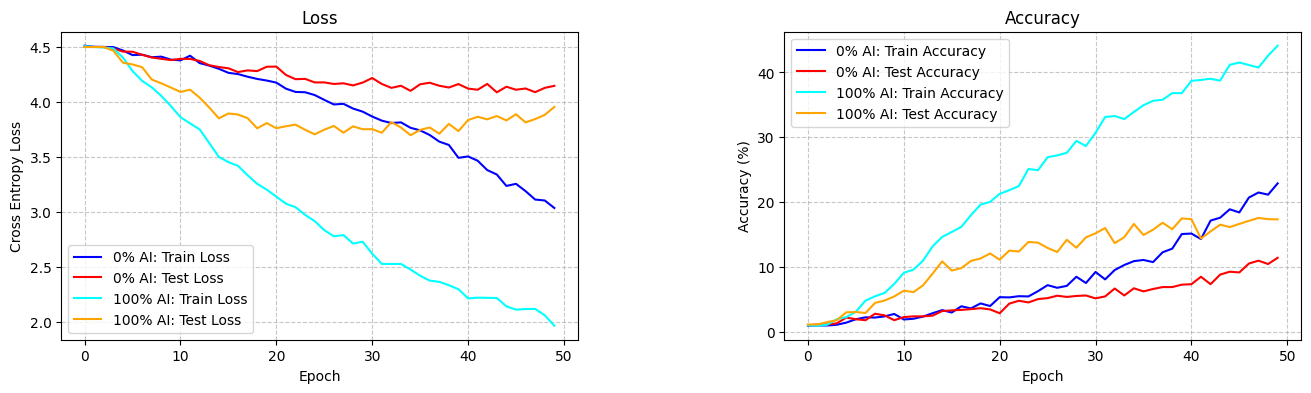

In [25]:
plot_loss_accuracy_diff(
    result_cnn_100real_0ai,
    result_cnn_100real_100ai,
    "0% AI: ",
    "100% AI: ",
)

In [20]:
plot_diff_table({
    "CNN: 100% real, 0% ai": result_cnn_100real_0ai,
    "CNN: 100% real, 50% ai": result_cnn_100real_50ai,
    "CNN: 100% real, 100% ai": result_cnn_100real_100ai,
    "CNN: 50% real, 100% ai": result_cnn_50real_100ai,
    "CNN: 0% real, 100% ai": result_cnn_0real_100ai,
}, "Comparison of Results by Metric for the CNN Model", DIFF_METRICS)

╭─────────────────────────┬──────────────────┬─────────────────┬──────────────────┬───────────────┬─────────────────╮
│                         │ Train Accuracy   │ Test Accuracy   │ Test Precision   │ Test Recall   │ Test F1 Score   │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 0% ai   │ 22.8889%         │ 11.4074%        │ 14.6854%         │ 11.4074%      │ 10.7273%        │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 50% ai  │ 33.3333%         │ 13.3333%        │ 18.9224%         │ 13.3333%      │ 13.1499%        │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 100% ai │ 44.1296%         │ 17.3333%        │ 20.8278%         │ 17.3333%      │ 17.2135%        │
├─────────────────────────┼──────────────────┼──────────

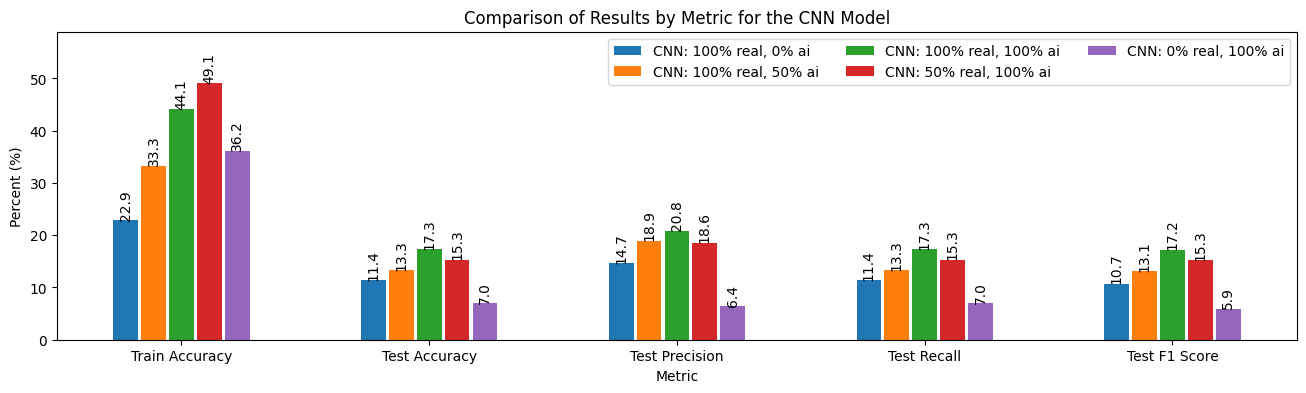

In [33]:
plot_diff_barchart({
    "CNN: 100% real, 0% ai": result_cnn_100real_0ai,
    "CNN: 100% real, 50% ai": result_cnn_100real_50ai,
    "CNN: 100% real, 100% ai": result_cnn_100real_100ai,
    "CNN: 50% real, 100% ai": result_cnn_50real_100ai,
    "CNN: 0% real, 100% ai": result_cnn_0real_100ai,
}, "Comparison of Results by Metric for the CNN Model", DIFF_METRICS)

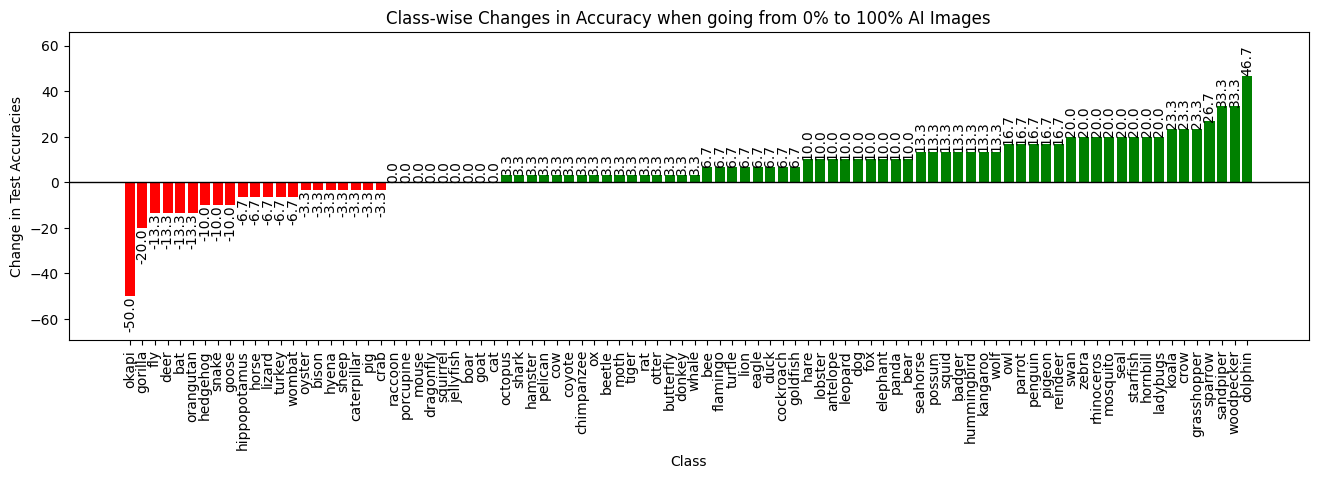

In [29]:
plot_improvement_by_class(result_cnn_100real_0ai, result_cnn_100real_100ai, "test_accuracies", CLASS_NAMES, "Class-wise Changes in Accuracy when going from 0% to 100% AI Images", 100.0)

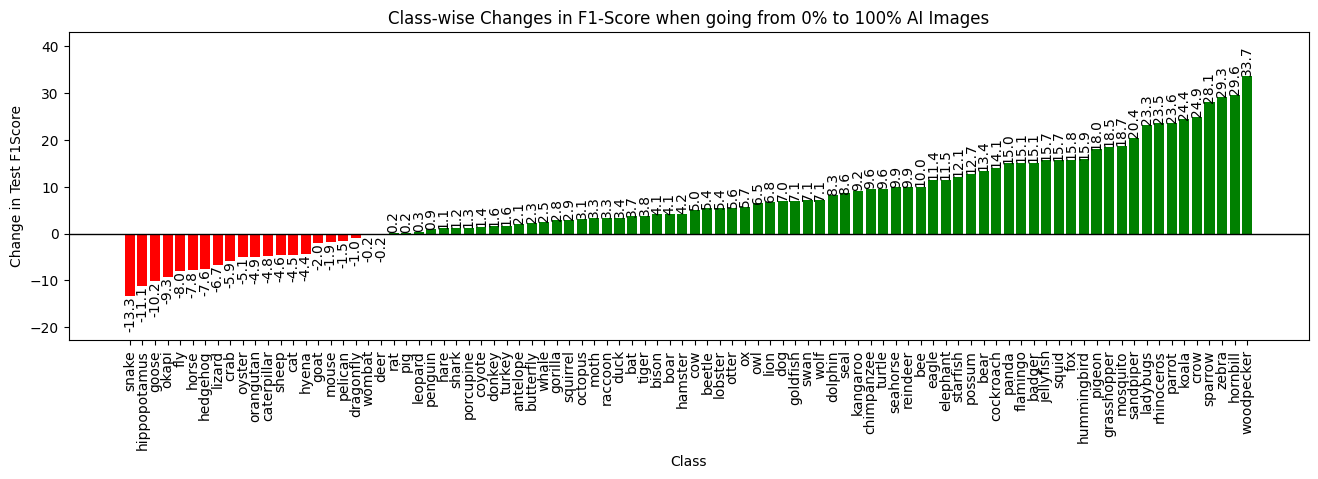

In [34]:
plot_improvement_by_class(result_cnn_100real_0ai, result_cnn_100real_100ai, "test_f1score", CLASS_NAMES, "Class-wise Changes in F1-Score when going from 0% to 100% AI Images", 100.0)

### Combined Pre-trained

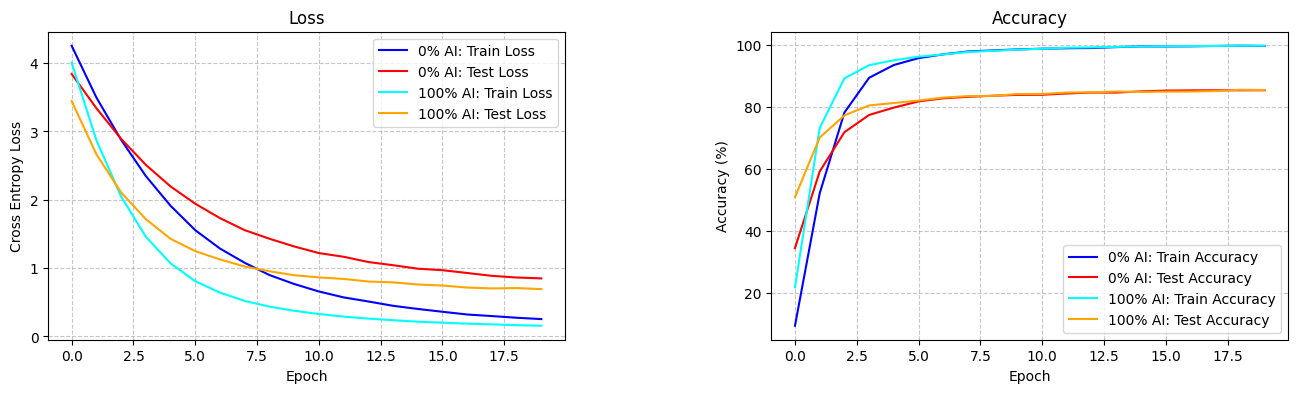

In [26]:
plot_loss_accuracy_diff(
    result_combined_100real_0ai,
    result_combined_100real_100ai,
    "0% AI: ",
    "100% AI: ",
)

In [27]:
plot_diff_table({
    "Combined: 100% real, 0% ai": result_combined_100real_0ai,
    "Combined: 100% real, 50% ai": result_combined_100real_50ai,
    "Combined: 100% real, 100% ai": result_combined_100real_100ai,
    "Combined: 50% real, 100% ai": result_combined_50real_100ai,
    "Combined: 0% real, 100% ai": result_combined_0real_100ai,
}, "Comparison of Results by Metric for the Combined Pre-trained Model", DIFF_METRICS)

╭──────────────────────────────┬──────────────────┬─────────────────┬──────────────────┬───────────────┬─────────────────╮
│                              │ Train Accuracy   │ Test Accuracy   │ Test Precision   │ Test Recall   │ Test F1 Score   │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 0% ai   │ 99.7778%         │ 85.4815%        │ 85.9232%         │ 85.4815%      │ 85.4437%        │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 50% ai  │ 99.8025%         │ 86.2963%        │ 86.9619%         │ 86.2963%      │ 86.3519%        │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 100% ai │ 99.8333%         │ 85.5556%        │ 86.3633%         │ 85.5556%      │ 85.5986%        │
├───────────────

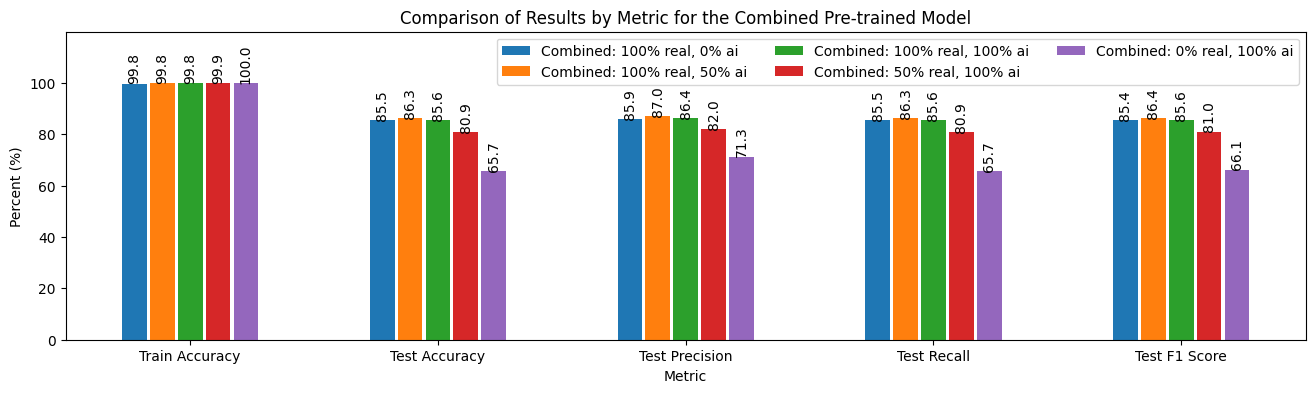

In [28]:
plot_diff_barchart({
    "Combined: 100% real, 0% ai": result_combined_100real_0ai,
    "Combined: 100% real, 50% ai": result_combined_100real_50ai,
    "Combined: 100% real, 100% ai": result_combined_100real_100ai,
    "Combined: 50% real, 100% ai": result_combined_50real_100ai,
    "Combined: 0% real, 100% ai": result_combined_0real_100ai,
}, "Comparison of Results by Metric for the Combined Pre-trained Model", DIFF_METRICS)

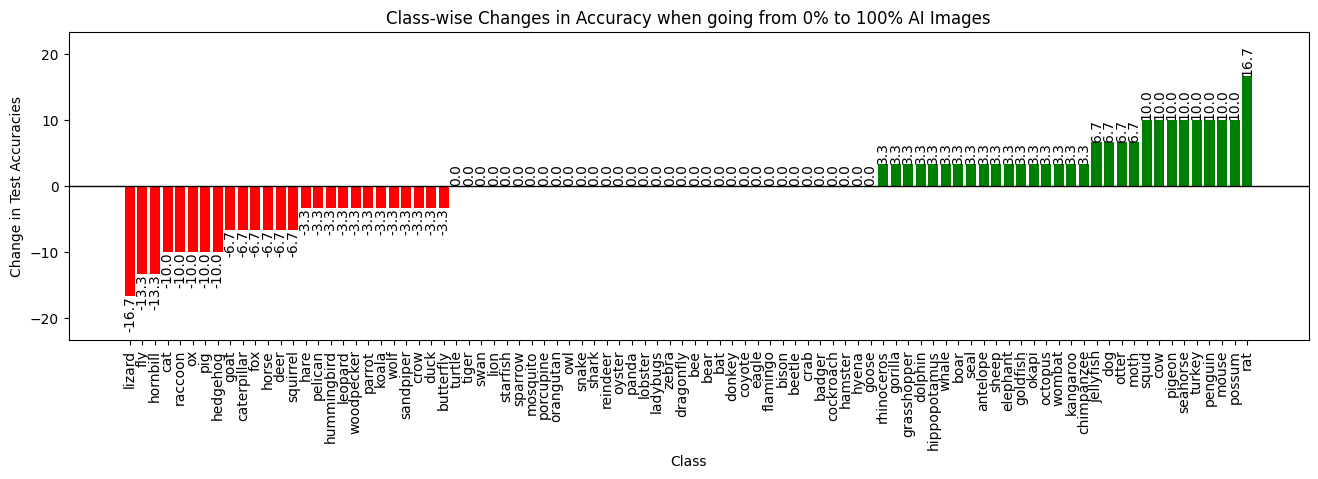

In [30]:
plot_improvement_by_class(result_combined_100real_0ai, result_combined_100real_100ai, "test_accuracies", CLASS_NAMES, "Class-wise Changes in Accuracy when going from 0% to 100% AI Images", 100.0)

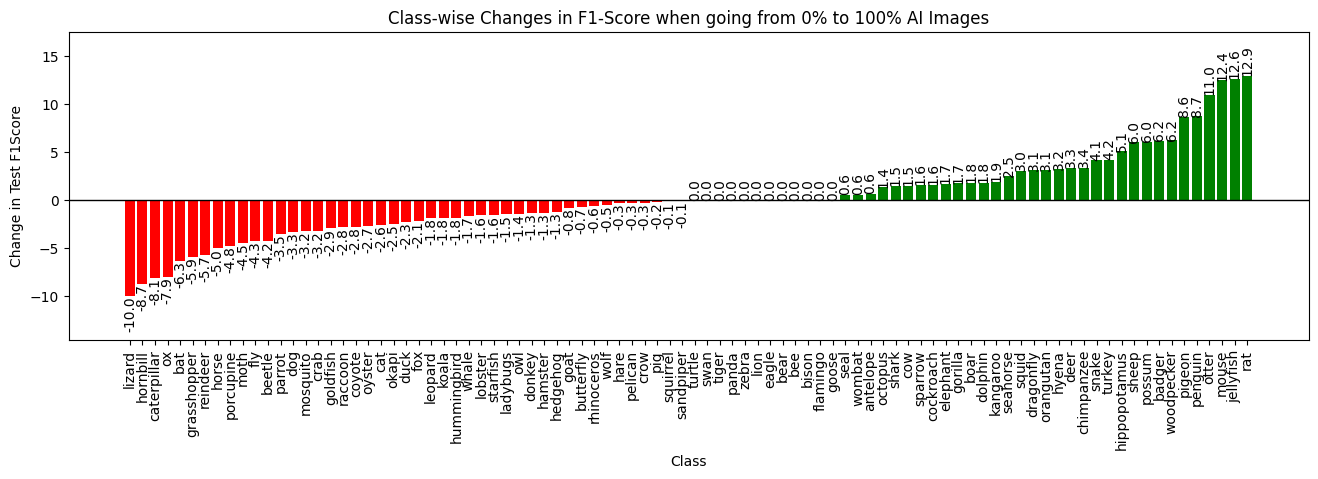

In [32]:
plot_improvement_by_class(result_combined_100real_0ai, result_combined_100real_100ai, "test_f1score", CLASS_NAMES, "Class-wise Changes in F1-Score when going from 0% to 100% AI Images", 100.0)